<a href="https://colab.research.google.com/github/laggyperson/URAP-Colab-ML-Notebooks/blob/main/URAP_MPC_Lab_Final_Research_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Traffic Light Data and Neural Networks to Predict Ego Vehicle Trajectory

# About this Notebook

The goal of this project is to use time series AI to predict the long horizon trajectory of an ego vehicle given a window of data. We have tested 4 differen models:
1. ARIMA Model (Linear model)
2. Simple Dense Neural Network
3. LSTMs
4. Transformers

In addition to this, we want to uncover whether traffic light data and neighboring lane information can provide crucial information for the prediction problem. There will be 4 versions of the data:
1. Only distance, speed, and acceleration
2. Same as 1, but with traffic light data
3. Same as 1, but with neighboring lane traffic data
4. Same as 1, but with both trafic light and neighboring lane traffic data

In [1]:
# Imports
# Utility Libraries
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
# Important paths:
home = "/content/drive/MyDrive/URAP - Trajectory Prediction/"
model_save_path = home + "models"
dataset_save_pat = home + "datasets"

## An Important Note

This notebook will have 2 versions of each cell, one for high frequency data, another for low frequency data.

# The Dataset

## Introducing the Dataset

The data is collected from running SUMO simulations (version 1.14) on a custom Gomentum map and several maps from CARLA. The code can be found here: https://github.com/laggyperson/URAP-Sumo-Data-Collection

All vehicle attributes are SUMO default values.

There are several different traffic light phases, including:
1. 10s green, 3s yellow, 3s red
2. 15s green, 3s yellow, 20s red
3. 15s green, 3s yellow, 15s red
4. 30s green, 3s yellow, 30s red

The data for neighboring traffic only includes the immediate lanes to the left and right.

There are two main frequencies that the data was collected at:
1. Every 0.5 seconds
2. Every 10 seconds
The goal is to see which may be better for long horizon predictions.

The simulations will be ran on 4 maps:
1. Gomentum
2. CARLA Town 01
3. CARLA Town 02
4. CARLA Town 03

Each will be ran such that there are 3000 time points for each vehicle (which translates to 25 minutes for the 0.5s frequency and 500 minutes for the 10s frequency).

## Importing the Datasets

In [3]:
# Higher frequency data  (period = 0.5s)
g16_100v_noLC_shortTL_ds = xr.open_dataset(home + "SUMO Data/High Freq/G16_100v_noLC.nc")
g16_100v_noLC_shortTL_arr = g16_100v_noLC_shortTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_100v_LC_shortTL_ds = xr.open_dataset(home + "SUMO Data/High Freq/G16_100v_LC.nc")
g16_100v_LC_shortTL_arr = g16_100v_LC_shortTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_100v_LC_longTL_ds = xr.open_dataset(home + "SUMO Data/High Freq/G16_100v_LC_longTL.nc")
g16_100v_LC_longTL_arr = g16_100v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_50v_LC_longTL_ds = xr.open_dataset(home + "SUMO Data/High Freq/G16_50v_LC_longTL.nc")
g16_50v_LC_longTL_arr = g16_50v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

g16_150v_LC_longTL_ds = xr.open_dataset(home + "SUMO Data/High Freq/G16_150v_LC_longTL.nc")
g16_150v_LC_longTL_arr = g16_150v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

town1_50v_LC_ds = xr.open_dataset(home + "SUMO Data/High Freq/Town01_50v_LC.nc")
town1_50v_LC_arr = town1_50v_LC_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

town3_100v_LC_longTL_ds = xr.open_dataset(home + "SUMO Data/High Freq/Town03_100v_LC_longTL.nc")
town3_100v_LC_longTL_arr = town3_100v_LC_longTL_ds["Data"].transpose("Veh IDs", "Time", "Data Labels")

# List of all arrays
arrs = [g16_100v_noLC_shortTL_arr, g16_100v_LC_shortTL_arr, g16_100v_LC_longTL_arr, g16_50v_LC_longTL_arr, g16_150v_LC_longTL_arr, town1_50v_LC_arr, town3_100v_LC_longTL_arr]

# Concatenating into one xarray
all_xarr = xr.concat(arrs, dim="Veh IDs")

In [4]:
# Cleaning up unnecessary variables for RAM management
del g16_100v_noLC_shortTL_ds
del g16_100v_noLC_shortTL_arr

del g16_100v_LC_shortTL_ds
del g16_100v_LC_shortTL_arr

del g16_100v_LC_longTL_ds
del g16_100v_LC_longTL_arr

del g16_50v_LC_longTL_ds
del g16_50v_LC_longTL_arr

del g16_150v_LC_longTL_ds
del g16_150v_LC_longTL_arr

del town1_50v_LC_ds
del town1_50v_LC_arr

del town3_100v_LC_longTL_ds
del town3_100v_LC_longTL_arr

del arrs

In [5]:
# Lower frequency data (period = 10s)

## Preprocessing the Datasets

### Getting rid of variables and re-ordering

In [6]:
# Reorder the features and only keep the wanted ones
all_xarr = all_xarr.sel({"Data Labels": ["Speed", "Max Speed", "Acceleration",
                                         "Traffic Light Distance", "Traffic Light Time to Switch", "Number of Vehicles to Traffic Light",
                                         "Number of Leading Vehicles", "Leading Vehicles Average Gap", "Leading Vehicles Average Speed", "Leading Vehicles Average Acceleration",
                                         "Right Lane Average Gap", "Right Lane Average Speed", "Right Lane Average Acceleration",
                                         "Left Lane Average Gap", "Left Lane Average Speed", "Left Lane Average Acceleration",
                                         "Distance to Edge", "Traffic Light State"]})
all_xarr

<xarray.DataArray 'Data' (Veh IDs: 650, Time: 3001, Data Labels: 18)>
array([[['18.390152568522385', '18.9528', '0.8214264653864873', ...,
         '-0.13300994134042554', '1021.1987353986297', 'g'],
        ['18.28064181341259', '18.9528', '-0.2190215102195907', ...,
         '-0.6645560110686333', '1012.0584144919233', 'g'],
        ['18.160346492138007', '18.9528', '-0.24059064254916507', ...,
         '0.9476307432865703', '1002.9782412458542', 'g'],
        ...,
        ['8.659697826588392', '18.9528', '-3.441478053702493', ...,
         '-1', '526.7502715656382', 'g'],
        ['8.047065081826997', '18.9528', '-1.2252654895227906', ...,
         '-1', '522.7267390247247', 'g'],
        ['8.14270366692757', '18.9528', '0.19127717020114687', ...,
         '-1', '518.6553871912608', 'g']],

       [['16.4144874021873', '16.571184', '0.3333378332317807', ...,
         '-1', '673.3318371694254', 'g'],
        ['16.31760772088856', '16.571184', '-0.19375936259748272', ...,
         '-1', '665.1730333089811', 'g'],
        ['16.356658424716084', '16.571184', '0.0781014076550477', ...,
         '-1', '656.9947040966233', 'g'],
...
        ['11.438811075428951', '11.902341', '-0.3506631542928531', ...,
         '-1', '211.51051662038583', 'G'],
        ...,
        ['0.0', '11.902341', '0.0', ..., '-1', '353.5851865526078', 'r'],
        ['0.0', '11.902341', '0.0', ..., '-1', '353.5851865526078', 'r'],
        ['0.0', '11.902341', '0.0', ..., '-1', '353.5851865526078', 'r']],

       [['2.7669771876147613', '13.991397000000001',
         '1.5982740048319108', ..., '-1', '183.8085308766456', 'g'],
        ['3.7330839037391024', '13.991397000000001',
         '1.9322134322486821', ..., '-1', '181.94198892477604', 'g'],
        ['4.8743539440989165', '13.991397000000001',
         '2.2825400807196283', ..., '-1', '179.50481195272658', 'g'],
        ...,
        ['7.048442315025595', '13.991397000000001', '2.536386380135081',
         ..., '-1', '660.4108991888874', 'r'],
        ['7.5970897693104', '13.991397000000001', '1.0972949085696104',
         ..., '-1', '656.6123543042322', 'r'],
        ['5.447667014811735', '13.991397000000001', '-4.29884550899733',
         ..., '-1', '653.8885207968264', 'r']]], dtype=object)
Coordinates:
  * Time         (Time) float64 0.0 0.5 1.0 1.5 ... 1.499e+03 1.5e+03 1.5e+03
  * Data Labels  (Data Labels) object 'Speed' ... 'Traffic Light State'
  * Veh IDs      (Veh IDs) object 'f_0.0' 'f_0.1' 'f_0.2' ... 'f_9.0' 'f_9.1'

### Sorting the variables

In [7]:
# Specify the numerical and categorical variables
categorical_vars = ["Traffic Light State"]
numeric_vars = [label for label in all_xarr["Data Labels"].data if label not in categorical_vars]

In [8]:
# New label order
labels = numeric_vars + categorical_vars

In [9]:
# Displays all features each data point has
for i in range(len(labels)):
  print(i, labels[i])

0 Speed
1 Max Speed
2 Acceleration
3 Traffic Light Distance
4 Traffic Light Time to Switch
5 Number of Vehicles to Traffic Light
6 Number of Leading Vehicles
7 Leading Vehicles Average Gap
8 Leading Vehicles Average Speed
9 Leading Vehicles Average Acceleration
10 Right Lane Average Gap
11 Right Lane Average Speed
12 Right Lane Average Acceleration
13 Left Lane Average Gap
14 Left Lane Average Speed
15 Left Lane Average Acceleration
16 Distance to Edge
17 Traffic Light State


### Preprocessing Numerical Data

In [10]:
# Getting numerical data into correct shape
single_ts = all_xarr.sel({"Data Labels": numeric_vars}).data.astype(float)
single_ts = np.concatenate(single_ts)

# Data to Normalize
numerical_data = all_xarr.sel({"Data Labels": numeric_vars}).data.astype(float)

In [11]:
# Getting rid of bad values from Distance to Edge
temp = single_ts[:, -1]
temp[temp < 0] = 0

temp = numerical_data[:, :, -1]
temp[temp < 0] = 0

In [12]:
# Normalizing the numerical data
num_mean = np.mean(single_ts, axis=0)
num_std = np.std(single_ts, axis=0)
numerical_data = (numerical_data - num_mean) / num_std

### Preprocessing Categorical Data

In [13]:
# Loading all categorical data into separate arrays
categorical_data_TL_state = all_xarr.sel({"Data Labels": "Traffic Light State"}).data

cat_dict = {
    "Traffic Light State": categorical_data_TL_state
}

In [14]:
# Encoding all the data
for label in categorical_vars:
  curr_arr = cat_dict[label]
  vocab = np.unique(curr_arr)
  encode = layers.StringLookup(vocabulary=vocab, output_mode="one_hot")
  encodings = encode(vocab).numpy()
  trans_dict = {vocab[i]: encodings[i] for i in range(len(vocab))}

  new_arr = []
  for ts in curr_arr:
    new_arr.append(np.array([trans_dict[w] for w in ts]))
  cat_dict[label] = np.array(new_arr)

In [15]:
print(cat_dict["Traffic Light State"].shape)

(650, 3001, 6)


In [16]:
# Recombining all categorical data data
categorical_data = np.concatenate(list(cat_dict.values()), axis=-1)
categorical_data.shape # The final dimension will be (TL State, Destination Edge, Destination Reached)

(650, 3001, 6)

### Combining the Data

In [17]:
# Recombining all data into a single numpy array
all_data = np.concatenate((numerical_data, categorical_data), axis=-1)
all_data.shape # Checking proper shape

(650, 3001, 23)

In [18]:
# Splitting the Data into training and test sets
# Distribution: 70% training, 20% validation, 10% test

steps = len(all_data[0])
# Slices
train_slice = slice(0, int(0.7 * steps))
validate_slice = slice(int(0.7 * steps), int(0.9 * steps))
test_slice = slice(int(0.9 * steps), None)
# Splitting each individual set
slice_func = lambda data, s: data[s]
train_ts = all_data[:, train_slice, :]
validate_ts = all_data[:, validate_slice, :]
test_ts = all_data[:, test_slice, :]

In [19]:
# # Clearing RAM
del all_xarr

del categorical_vars
del numeric_vars

del single_ts
del numerical_data
del temp

del categorical_data_TL_state
del cat_dict

del label
del curr_arr
del vocab
del encode
del encodings
del trans_dict
del new_arr
del ts

del categorical_data

del steps
del train_slice
del validate_slice
del test_slice
del slice_func

## Window Class

This code is a modification of code from the Time Series Forecasting tutorial written by Tensorflow: https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing

It helps create data points for creating the Tensorflow datasets as well as allow for the data to be plotted.

In [20]:
# Creating a Window class

class WindowGenerator():
  def __init__(self, input_width, label_width, shift, stride,
               all_labels, input_columns=None, label_columns=None):
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.stride = stride

    self.all_labels = all_labels
    self.column_indices = {all_labels[i]: slice(i, i + 1) for i in range(len(all_labels))}
    self.column_indices["Traffic Light State"] = slice(self.column_indices["Traffic Light State"].start, self.column_indices["Traffic Light State"].start + 5)

    if input_columns is not None:
      self.input_columns = input_columns
      self.input_columns_indices = {column: self.column_indices[column] for column in input_columns}

      i = 1
      tmp_keys = list(self.input_columns_indices.keys())
      while i < len(tmp_keys):
        diff = self.input_columns_indices[tmp_keys[i]].start - self.input_columns_indices[tmp_keys[i - 1]].stop # Finding if there is a gap greater than 1 to shrink
        if diff > 0:
          self.input_columns_indices[tmp_keys[i]] = slice(self.input_columns_indices[tmp_keys[i]].start - diff, self.input_columns_indices[tmp_keys[i]].stop - diff)
        i += 1

    else:
      self.input_columns = all_labels
      self.input_columns_indices = self.column_indices

    if label_columns is not None:
      self.label_columns_indices = {column: self.column_indices[column] for column in label_columns}
      i = 1
      tmp_keys = list(self.label_columns_indices.keys())
      while i < len(tmp_keys):
        diff = self.label_columns_indices[tmp_keys[i]].start - self.label_columns_indices[tmp_keys[i - 1]].stop # Finding if there is a gap greather than 1 to shrink
        if diff > 0:
          self.label_columns_indices[tmp_keys[i]] = slice(self.label_columns_indices[tmp_keys[i]].start - diff, self.label_columns_indices[tmp_keys[i]].stop - diff)
        i += 1

    self.label_columns = label_columns

    self.total_window_size = input_width + label_width # Assuming that shift is always size of input

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, self.total_window_size)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    self.count = 0

  def make_window(self, time_series):
    # Input Shape: (2401, 44) = (# of time steps, # of features)
    # Output Shape: (# of windows, # of time steps per window, # of features)
    w_start, w_end = 0, self.total_window_size
    stride = self.stride

    res = []
    while w_end < len(time_series):
      window = time_series[w_start: w_end]
      # Only add windows with no change in destination
      add = True
      distance_ind = self.column_indices["Distance to Edge"]
      for i in range(1, len(window)):
        # If the distance jumps up by enough, means this window is not wanted
        if (window[i - 1, distance_ind] - window[i, distance_ind]) < 0:
          add = False
          break
      if add:
        res.append(window)
      w_start += stride
      w_end += stride

    return res

  def make_dataset(self, data):
    # ============================= Non-transformer =============================
    # The data is in the shape (550, 2401, 44) = (# of veh series, # of time steps, preprocessed features)
    # The returned dataset should be in the shape:
    # (_, 2) = (# of batches, dimension of each example)
    # Each example: ((32, 40, 44), (32, 40, 2)) = (features, labels)
    # = ((# of examples per batch, # of time steps in input, # of features in input), (# of examples per batch, # of time steps in labels, # of features in labels))

    # Window each time series
    # Output Shape: (550, # of windows, # of time steps per window, # of features=44)
    # Issue: Non homogenous 2nd dimension (each time series may have different amount of filtered windows): can't use numpy
    data = [self.make_window(ts) for ts in data]

    # Stacking all windows together
    # Shape: (# of windows, # of time stps per window, # of features=44)
    data = np.array([win for ts in data for win in ts])

    # Get the features
    # (# of windows, # of time steps, # of features)
    feature_examples = data[:, self.input_slice, :]
    feature_examples = np.concatenate([feature_examples[:, :, self.column_indices[label]] for label in self.input_columns], -1)

    # Get the labels
    label_examples = data[:, self.labels_slice, :]
    if self.label_columns is not None:
      label_examples = np.concatenate([label_examples[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Make the dataset
    ds = tf.data.Dataset.from_tensor_slices((feature_examples, label_examples))
    ds = ds.batch(32).shuffle(100)
    return ds

    # # ============================= Transformers =============================:
    # # Slightly different input to allow for autoregression
    # # Each example: ((32, 2, 40, 44), (32, 40 , 2)) = (features, labels)
    # # = ((batch size, 2, window size, # of features), (batch size, window size, # of features))
    # # The 2 comes from having the actual input and the corresponding label, but shifted one step backwards

    # # Window each time series
    # # Output Shape: (550, # of windows, # of time steps per window, # of features)
    # # Issue: Non homogenous 2nd dimension (each time series may have different amount of filtered windows): can't use numpy
    # data = [self.make_window(ts) for ts in data]

    # # Stacking all windows together
    # # Shape: (# of windows, # of time stps per window, # of features=44)
    # data = np.array([win for ts in data for win in ts])

    # # Get the features
    # # (# of windows, # of time steps, # of features)
    # feature_examples = data[:, self.input_slice, :]
    # feature_examples = np.concatenate([feature_examples[:, :, self.column_indices[label]] for label in self.input_columns], -1)
    # # For transformers: input data needs to have the output example, shifted over by 1
    # slice_shift = slice(self.labels_slice.start - 1, self.labels_slice.stop - 1)
    # feature_examples_2 = data[:, slice_shift, :]
    # feature_examples_2 = np.concatenate([feature_examples_2[:, :, self.column_indices[label]] for label in self.label_columns], -1)

    # feature_examples = np.expand_dims(feature_examples, axis=1)
    # feature_examples_2 = np.expand_dims(feature_examples_2, axis=1)
    # feature_examples = np.concatenate((feature_examples, feature_examples_2), axis=1)

    # # Get the labels
    # label_examples = data[:, self.labels_slice, :]
    # if self.label_columns is not None:
    #   label_examples = np.concatenate([label_examples[:, :, self.column_indices[name]] for name in self.label_columns],
    #       axis=-1)

    # # Make the dataset
    # ds = tf.data.Dataset.from_tensor_slices((feature_examples, label_examples))
    # ds = ds.batch(32).shuffle(100)
    # return ds

  def plot(self, data, model=None, plot_col='Distance to Edge', max_subplots=3):
    plt.figure(figsize=(12, 3 * max_subplots)) # Setting size: will dynamically resize based on the number of subplots
    plot_col_index = self.input_columns_indices[plot_col] # Index of which feature to plot

    # Plotting each subplot
    plot_num = 1 # Keep track of which plot is current
    for input, label in data.take(max_subplots): # Grabbing feature and data
      # For normal implementation
      plot_input = input

      # # For Transformers implementation
      # plot_input = input[:, 0, :, :]

      plt.subplot(max_subplots, 1, plot_num) # Specify which one currently plotting

      plt.ylabel(f'{plot_col} [normed]') # Label y axis
      plt.plot(self.input_indices, plot_input.numpy()[plot_num, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)  # Plot the blue line that represents the input

      # Finding feature index to extract from the returned labels (since it may differ in shape than the input)
      if self.label_columns:
        label_col_index = self.label_columns_indices[plot_col]
      else:
        label_col_index = plot_col_index

      if label_col_index is None: # If it isn't found
        continue

      # Don't use label_col_index for transformers, use ":"
      plt.scatter(self.label_indices, label.numpy()[plot_num, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64) # Plot the expected labels as green dots
      if model is not None: # Using model to make predictions
        predictions = np.asarray(model(input)) # Calling model on inputs
        plt.scatter(self.label_indices, predictions[plot_num, :, label_col_index], # Plotting predictions, extracting the label wanted
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if plot_num == 1: # First plot we want to plot the legend
        plt.legend()

      plot_num += 1

    plt.xlabel('Time (s)') # Label x-axis

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.test))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Creating Window object and Tensorflow Datasets

Will create 4 of them for the 4 different datasets.

Can only run one at a time to save RAM.

Here is the window visualized

```
<--------------------------------------- One Example -------------------------------------->
<----------- Shift AND Stride ----------->
                                         |
| 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
                                         |
 ^                                         ^
First input time step                      First output time step
AND First output time step of              AND First input time step of next
previous example                           example
```

### Dataset 1

In [22]:
# Dataset 1: Just speed, acceleration, and distance to destination
labels_1 = ["Speed", "Acceleration", "Distance to Edge"]
window_1 = WindowGenerator(10, 10, 10, 10, labels, labels_1, labels_1)

In [54]:
# Creating datasets
ds1_train = window_1.make_dataset(train_ts)
ds1_val = window_1.make_dataset(validate_ts)
ds1_test = window_1.make_dataset(test_ts)

In [71]:
# For freeing RAM
del ds1_train
del ds1_val
del ds1_test
del window_1

### Dataset 2

In [72]:
# Dataset 2: Same as Dataset 1, but with traffic light data
labels_2 = labels_1 + ["Traffic Light Distance", "Traffic Light Time to Switch", "Number of Vehicles to Traffic Light", "Traffic Light State"]
window_2 = WindowGenerator(10, 10, 10, 10, labels, labels_2, labels_2)

In [73]:
# Creating datasets
ds2_train = window_2.make_dataset(train_ts)
ds2_val = window_2.make_dataset(validate_ts)
ds2_test = window_2.make_dataset(test_ts)

In [89]:
# For freeing RAM
del ds2_train
del ds2_val
del ds2_test
del window_2

### Dataset 3

In [23]:
# Dataset 3: Same as Dataset 1, but with neighboring traffic data
labels_3 = labels_1 + ["Number of Leading Vehicles", "Leading Vehicles Average Gap", "Leading Vehicles Average Speed", "Leading Vehicles Average Acceleration",
                       "Right Lane Average Gap", "Right Lane Average Speed", "Right Lane Average Acceleration",
                       "Left Lane Average Gap", "Left Lane Average Speed", "Left Lane Average Acceleration"]
window_3 = WindowGenerator(10, 10, 10, 10, labels, labels_3, labels_3)

In [24]:
# Creating datasets
ds3_train = window_3.make_dataset(train_ts)
ds3_val = window_3.make_dataset(validate_ts)
ds3_test = window_3.make_dataset(test_ts)

In [37]:
# For freeing RAM
del ds3_train
del ds3_val
del ds3_test
del window_3

### Dataset 4

In [38]:
# All labels
window_4 = WindowGenerator(10, 10, 10, 10, labels, labels, labels)

In [39]:
# Create datasets
ds4_train = window_4.make_dataset(train_ts)
ds4_val = window_4.make_dataset(validate_ts)
ds4_test = window_4.make_dataset(test_ts)

In [49]:
# For freeing RAM
del ds4_train
del ds4_val
del ds4_test
del window_4

# The Models

## Training Setup

In [25]:
# Used in some of the models
OUTPUT_STEPS = 10

In [26]:
# For changing the number of training cycles
MAX_EPOCHS = 50

In [27]:
# Using MeanSquaredError loss since distance is being predicted
# The extra hyperparameters were optimized through experiment
def compile(model, use_LSTM_opt=False, loss=keras.losses.MeanSquaredError()):
  if use_LSTM_opt:
    model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(),
                  weight_decay=0.004, learning_rate=0.005,
                  use_ema=True, ema_momentum=0.5, run_eagerly=True)
  else:
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam())

In [28]:
# Has a patience parameter to end training early if no improvements are being made
def fit(model, train_data, val_data, patience=40, epochs=MAX_EPOCHS):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  return model.fit(train_data, epochs=epochs, validation_data=val_data,callbacks=[early_stopping])

## ARIMA Model

### Creating the model

#### Dataset 1 - Distance, Speed, Acceleration

#### Dataset 2 - 1 + Traffic Light Data

#### Dataset 3 - 1 + Neighboring Traffic Data

#### Dataset 4 - 1 + Traffic Light Data + Neighboring Traffic Data

### Training the Model

#### Dataset 1 - Distance, Speed, Acceleration

#### Dataset 2 - 1 + Traffic Light Data

#### Dataset 3 - 1 + Neighboring Traffic Data

#### Dataset 4 - 1 + Traffic Light Data + Neighboring Traffic Data

## Dense Neural Network

Overall Observations:
* The training loss curves don't change much at all, meaning it is unable to really learn the time series data
  * Testament to the inability of Dense Neural Networks to work with time series data
* Doesn't generalize well

### High Frequency Data

#### Dataset 1 - Distance, Speed, Acceleration

My results:
Training Loss - 0.4012

Validation Loss - 0.4181

Test Loss - 0.4086

Plot observations (Distance to Edge):
* Struggles to match first time step of the output curve, creating an offset
  * happens less with flatter input/output
* Occasionally matches the shape of the output
* Still has some noise in the output, sometimes a lot

In [42]:
num_features = 3

In [58]:
dense_model_ds1 = keras.Sequential([
    layers.Dense(256),
    layers.Dense(1024),
    layers.Dense(512),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(num_features,
                 kernel_initializer=tf.initializers.zeros())
])

In [63]:
compile(dense_model_ds1)

In [64]:
with tf.device("/GPU:0"):
  history = fit(dense_model_ds1, ds1_train, ds1_val)

Epoch 1/50
3884/3884 [==============================] - 25s 6ms/step - loss: 0.4071 - val_loss: 0.4178
Epoch 2/50
3884/3884 [==============================] - 22s 6ms/step - loss: 0.4036 - val_loss: 0.4164
Epoch 3/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4028 - val_loss: 0.4165
Epoch 4/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4030 - val_loss: 0.4226
Epoch 5/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4017 - val_loss: 0.4126
Epoch 6/50
3884/3884 [==============================] - 23s 6ms/step - loss: 0.4022 - val_loss: 0.4159
Epoch 7/50
3884/3884 [==============================] - 22s 6ms/step - loss: 0.4028 - val_loss: 0.4207
Epoch 8/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4016 - val_loss: 0.4167
Epoch 9/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4018 - val_loss: 0.4178
Epoch 10/50
3884/3884 [==============================] - 24s 6ms/step - l

In [65]:
dense_model_ds1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 10, 256)           1024      
                                                                 
 dense_17 (Dense)            (None, 10, 1024)          263168    
                                                                 
 dense_18 (Dense)            (None, 10, 512)           524800    
                                                                 
 dense_19 (Dense)            (None, 10, 3)             1539      
                                                                 
Total params: 790531 (3.02 MB)
Trainable params: 790531 (3.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
# Evaluating the model with the test set
dense_model_ds1.evaluate(ds1_test)

544/544 [==============================] - 2s 3ms/step - loss: 0.4086


0.40862634778022766

In [68]:
# Saving the model
dense_model_ds1.save(model_save_path + "/Dense/dense_model_ds1.keras")

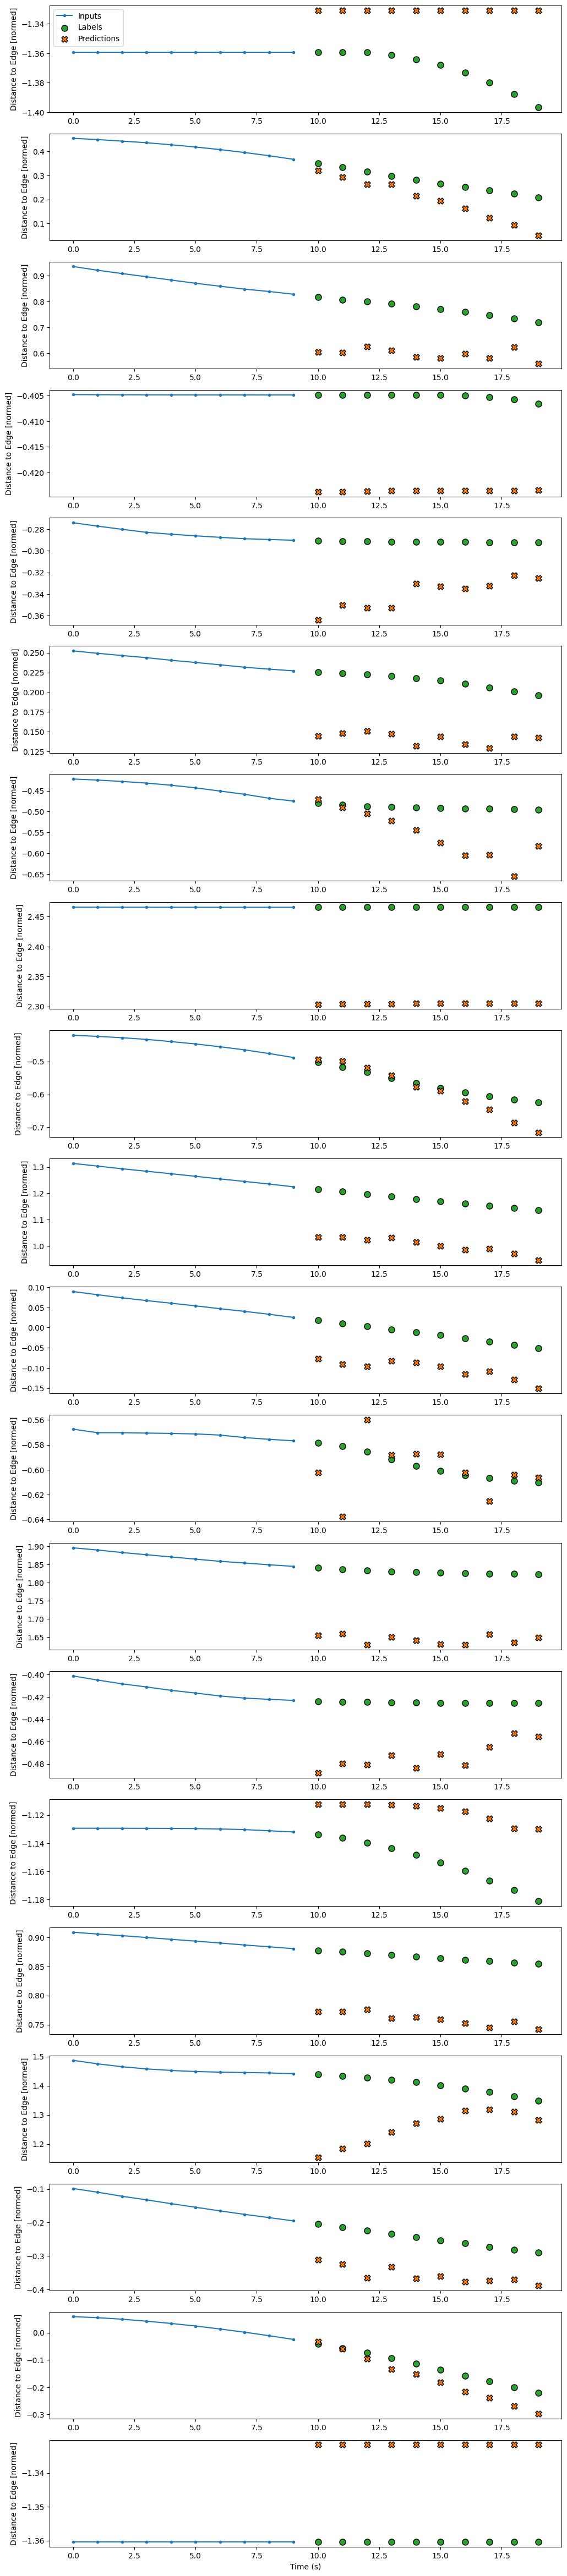

In [70]:
window_1.plot(ds1_test, dense_model_ds1, max_subplots=20)

#### Dataset 2 - 1 + Traffic Light Data

My results:
Training Loss - 0.2537

Validation Loss - 0.3531

Test Loss - 0.4025

Plot observations (Distance to Edge):
* Output is much noisier - no longer matching the shape of the output
  * Possibly because of the model trying to match the output for the other features
* First output data point is much closer to the last input data point
* More random jumps in the prediction

In [81]:
num_features = 11

In [82]:
dense_model_ds2 = keras.Sequential([
    layers.Dense(256),
    layers.Dense(1024),
    layers.Dense(512),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(num_features,
                 kernel_initializer=tf.initializers.zeros())
])

In [83]:
compile(dense_model_ds2)

In [84]:
with tf.device("/GPU:0"):
  history = fit(dense_model_ds2, ds2_train, ds2_val)

Epoch 1/50
3884/3884 [==============================] - 27s 7ms/step - loss: 0.2655 - val_loss: 0.3638
Epoch 2/50
3884/3884 [==============================] - 25s 6ms/step - loss: 0.2601 - val_loss: 0.3527
Epoch 3/50
3884/3884 [==============================] - 26s 7ms/step - loss: 0.2571 - val_loss: 0.3597
Epoch 4/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.2647 - val_loss: 0.3664
Epoch 5/50
3884/3884 [==============================] - 23s 6ms/step - loss: 0.2559 - val_loss: 0.3775
Epoch 6/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.2561 - val_loss: 0.3542
Epoch 7/50
3884/3884 [==============================] - 25s 6ms/step - loss: 0.2559 - val_loss: 0.3462
Epoch 8/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.2566 - val_loss: 0.3664
Epoch 9/50
3884/3884 [==============================] - 23s 6ms/step - loss: 0.2555 - val_loss: 0.3593
Epoch 10/50
3884/3884 [==============================] - 24s 6ms/step - l

In [85]:
dense_model_ds2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 10, 256)           3072      
                                                                 
 dense_25 (Dense)            (None, 10, 1024)          263168    
                                                                 
 dense_26 (Dense)            (None, 10, 512)           524800    
                                                                 
 dense_27 (Dense)            (None, 10, 11)            5643      
                                                                 
Total params: 796683 (3.04 MB)
Trainable params: 796683 (3.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
# Evaluating the model with the test set
dense_model_ds2.evaluate(ds2_test)

544/544 [==============================] - 2s 3ms/step - loss: 0.4025


0.40248391032218933

In [87]:
# Saving the model
dense_model_ds2.save(model_save_path + "/Dense/dense_model_ds2.keras")

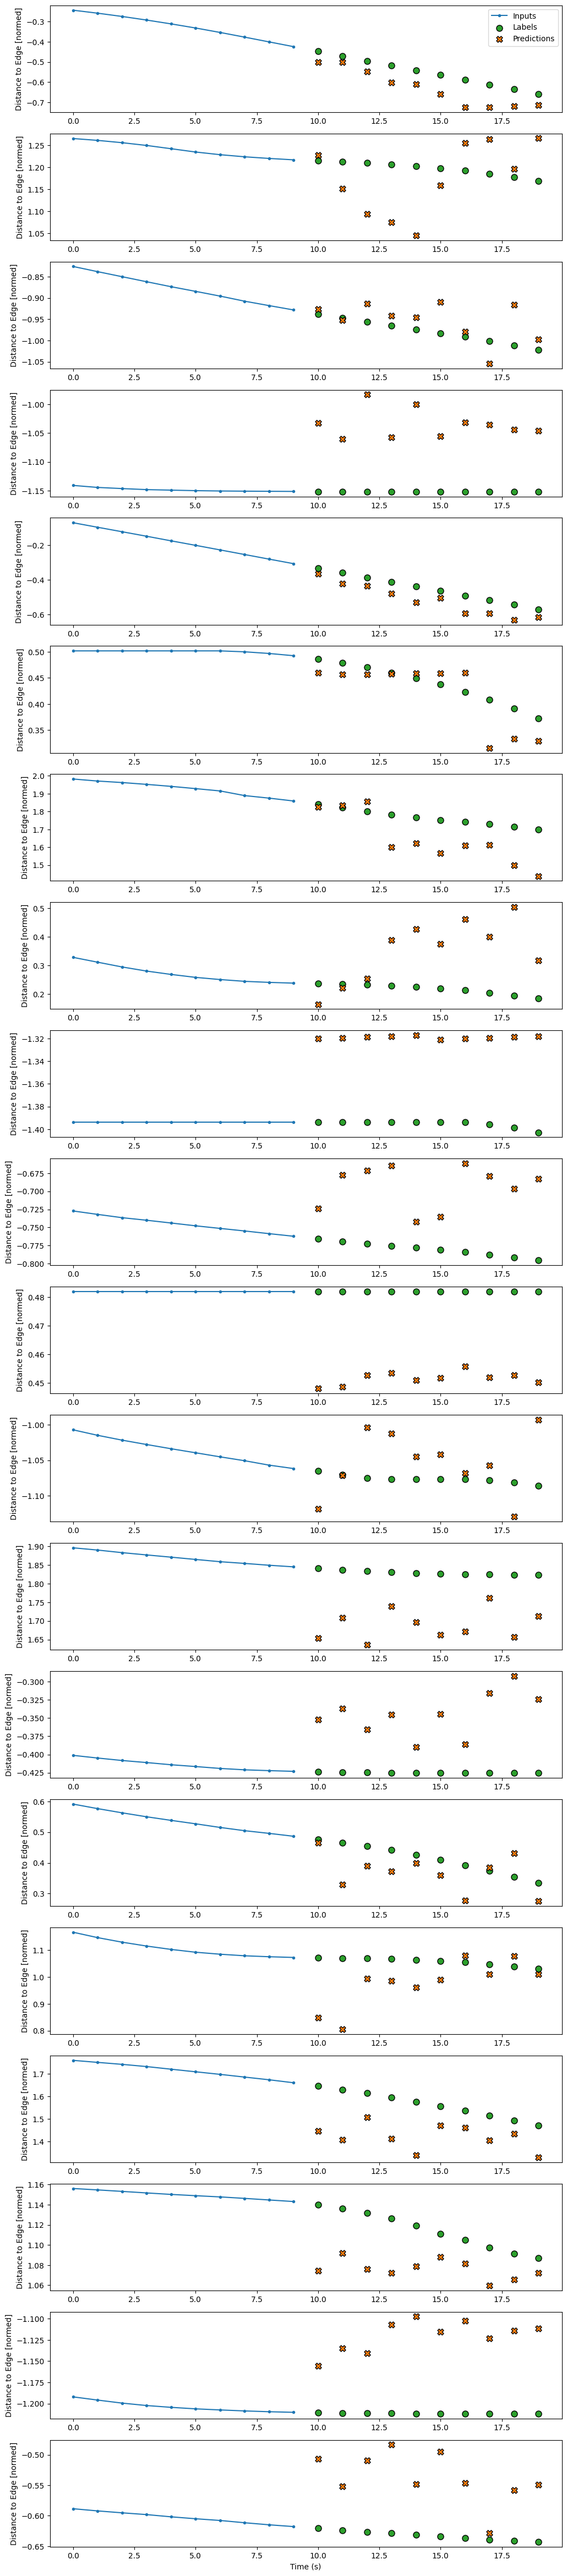

In [88]:
window_2.plot(ds2_test, dense_model_ds2, max_subplots=20)

#### Dataset 3 - 1 + Neighboring Traffic Data

My results:
Training Loss - 0.6142

Validation Loss - 0.6548

Test Loss - 0.6502

Plot observations (Distance to Edge):
* Output has quite a bit of noise, espescially when the output should be flat.
  * Is occasionally able to match the shape well
  * Sometimes seems to be predicting the shape of another feature, creating peaks in the output (which shouldn't be there for distance data)
  * The random jumps may be because the data for the neighboring traffic contains more discrete jumps as there are stretches of road where there is no neighboring traffic
* Still fails to match the last input time step
* Shows no understanding of continuity of data

In [29]:
num_features = 13

In [30]:
dense_model_ds3 = keras.Sequential([
    layers.Dense(256),
    layers.Dense(1024),
    layers.Dense(512),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(num_features,
                 kernel_initializer=tf.initializers.zeros())
])

In [31]:
compile(dense_model_ds3)

In [32]:
with tf.device("/GPU:0"):
  history = fit(dense_model_ds3, ds3_train, ds3_val)

Epoch 1/50
3884/3884 [==============================] - 201s 51ms/step - loss: 0.6275 - val_loss: 0.6732
Epoch 2/50
3884/3884 [==============================] - 205s 53ms/step - loss: 0.6205 - val_loss: 0.6635
Epoch 3/50
3884/3884 [==============================] - 203s 52ms/step - loss: 0.6184 - val_loss: 0.6616
Epoch 4/50
3884/3884 [==============================] - 207s 53ms/step - loss: 0.6170 - val_loss: 0.6636
Epoch 5/50
3884/3884 [==============================] - 198s 51ms/step - loss: 0.6172 - val_loss: 0.6572
Epoch 6/50
3884/3884 [==============================] - 201s 52ms/step - loss: 0.6167 - val_loss: 0.6623
Epoch 7/50
3884/3884 [==============================] - 199s 51ms/step - loss: 0.6162 - val_loss: 0.6617
Epoch 8/50
3884/3884 [==============================] - 203s 52ms/step - loss: 0.6170 - val_loss: 0.6558
Epoch 9/50
3884/3884 [==============================] - 215s 55ms/step - loss: 0.6166 - val_loss: 0.6603
Epoch 10/50
3884/3884 [==============================] 

In [33]:
dense_model_ds3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10, 256)           3584      
                                                                 
 dense_1 (Dense)             (None, 10, 1024)          263168    
                                                                 
 dense_2 (Dense)             (None, 10, 512)           524800    
                                                                 
 dense_3 (Dense)             (None, 10, 13)            6669      
                                                                 
Total params: 798221 (3.04 MB)
Trainable params: 798221 (3.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
# Evaluating the model with the test set
dense_model_ds3.evaluate(ds3_test)

544/544 [==============================] - 9s 17ms/step - loss: 0.6502


0.6502183079719543

In [35]:
# Saving the model
dense_model_ds3.save(model_save_path + "/Dense/dense_model_ds3.keras")

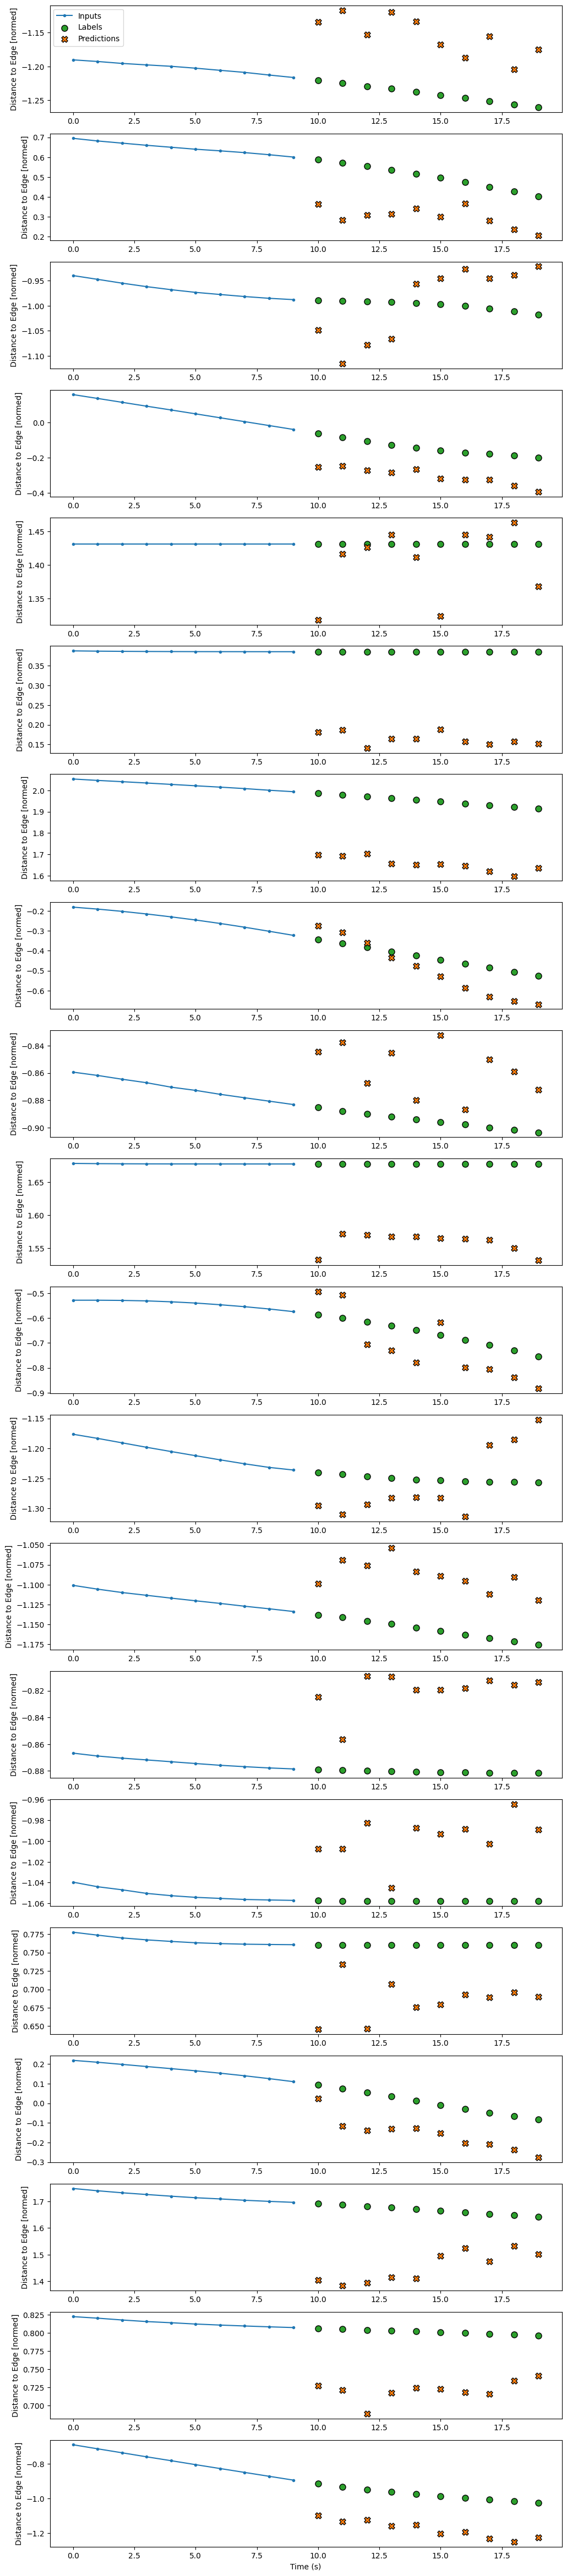

In [36]:
window_3.plot(ds3_test, dense_model_ds3, max_subplots=20)

#### Dataset 4 - 1 + Traffic Light Data + Neighboring Traffic Data

My results:

Training Loss - 0.4772

Validation Loss - 0.5382

Test Loss - 0.5604

Plot observations (Distance to Edge):
* Outpute is a little noisy
* Somewhat caputres the shape of the output
  * Does not seem to understand that the continuous output should always be decreasing
  * That, along with large jumps in the output, may be caused by the model trying to fit to the other features
* The first time step of the output does not match well with the last input time step
* Seems to do better than the other models

In [41]:
num_features = 22

In [42]:
dense_model_ds4 = keras.Sequential([
    layers.Dense(256),
    layers.Dense(1024),
    layers.Dense(512),

    # Creating output dimension: should be number of steps to predict times the number of features
    layers.Dense(num_features,
                 kernel_initializer=tf.initializers.zeros())
])

In [43]:
compile(dense_model_ds4)

In [44]:
with tf.device("/GPU:0"):
  history = fit(dense_model_ds4, ds4_train, ds4_val)

Epoch 1/50
3884/3884 [==============================] - 25s 6ms/step - loss: 0.4633 - val_loss: 0.5426
Epoch 2/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4538 - val_loss: 0.5406
Epoch 3/50
3884/3884 [==============================] - 25s 6ms/step - loss: 0.4531 - val_loss: 0.5366
Epoch 4/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4497 - val_loss: 0.5481
Epoch 5/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4495 - val_loss: 0.5524
Epoch 6/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4499 - val_loss: 0.5289
Epoch 7/50
3884/3884 [==============================] - 22s 6ms/step - loss: 0.4491 - val_loss: 0.5397
Epoch 8/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4486 - val_loss: 0.5241
Epoch 9/50
3884/3884 [==============================] - 24s 6ms/step - loss: 0.4485 - val_loss: 0.5386
Epoch 10/50
3884/3884 [==============================] - 23s 6ms/step - l

In [45]:
dense_model_ds4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10, 256)           5888      
                                                                 
 dense_5 (Dense)             (None, 10, 1024)          263168    
                                                                 
 dense_6 (Dense)             (None, 10, 512)           524800    
                                                                 
 dense_7 (Dense)             (None, 10, 22)            11286     
                                                                 
Total params: 805142 (3.07 MB)
Trainable params: 805142 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# Evaluating the model with the test set
dense_model_ds4.evaluate(ds4_test)

544/544 [==============================] - 2s 3ms/step - loss: 0.5604


0.560414731502533

In [47]:
# Saving the model
dense_model_ds4.save(model_save_path + "/Dense/dense_model_ds4.keras")

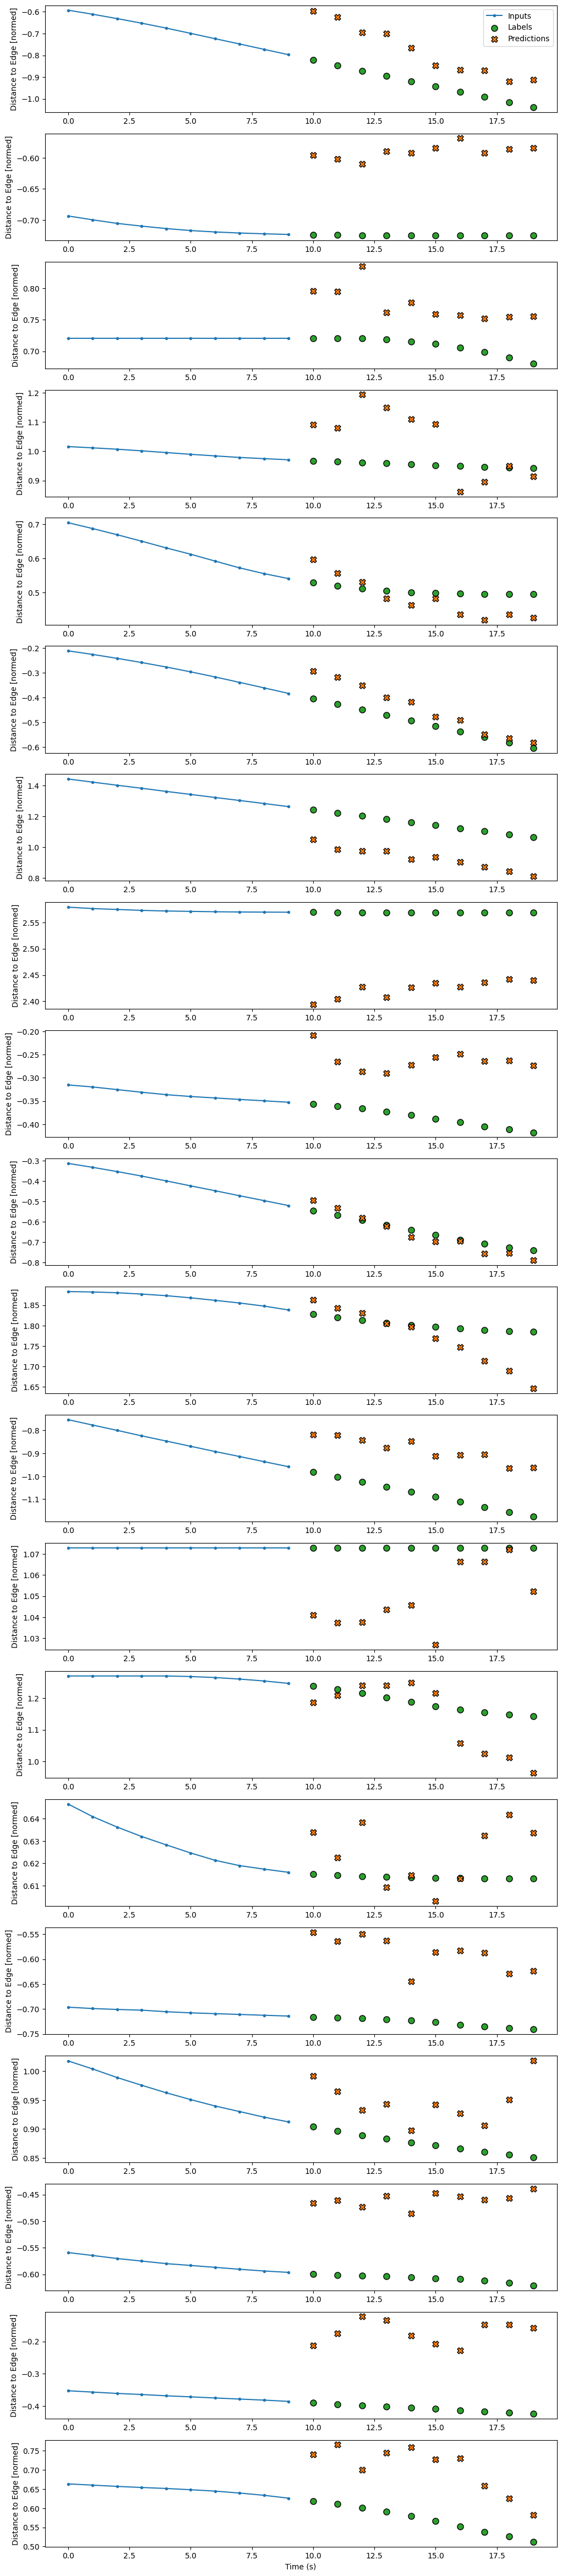

In [48]:
window_4.plot(ds4_test, dense_model_ds4, max_subplots=20)

## LSTM

### Creating the models

#### Dataset 1 - Distance, Speed, Acceleration

#### Dataset 2 - 1 + Traffic Light Data

#### Dataset 3 - 1 + Neighboring Traffic Data

#### Dataset 4 - 1 + Traffic Light Data + Neighboring Traffic Data

### Training the Model

#### Dataset 1 - Distance, Speed, Acceleration

#### Dataset 2 - 1 + Traffic Light Data

#### Dataset 3 - 1 + Neighboring Traffic Data

#### Dataset 4 - 1 + Traffic Light Data + Neighboring Traffic Data

## Autoregressive LSTM

### Creating the models

#### Dataset 1 - Distance, Speed, Acceleration

#### Dataset 2 - 1 + Traffic Light Data

#### Dataset 3 - 1 + Neighboring Traffic Data

#### Dataset 4 - 1 + Traffic Light Data + Neighboring Traffic Data

### Training the Model

#### Dataset 1 - Distance, Speed, Acceleration

#### Dataset 2 - 1 + Traffic Light Data

#### Dataset 3 - 1 + Neighboring Traffic Data

#### Dataset 4 - 1 + Traffic Light Data + Neighboring Traffic Data

## Transformer

### Creating the models

#### Dataset 1 - Distance, Speed, Acceleration

#### Dataset 2 - 1 + Traffic Light Data

#### Dataset 3 - 1 + Neighboring Traffic Data

#### Dataset 4 - 1 + Traffic Light Data + Neighboring Traffic Data

### Training the Model

#### Dataset 1 - Distance, Speed, Acceleration

#### Dataset 2 - 1 + Traffic Light Data

#### Dataset 3 - 1 + Neighboring Traffic Data

#### Dataset 4 - 1 + Traffic Light Data + Neighboring Traffic Data

# Testing

## Validation and Testing Loss Comparisons

## Short-Horizon Prediction Graphs

## Long Horizon Predictions

Long Horizon predictions means that we want the model to predict a vehicle's trajectory for an entire trip from start to finish. We will feed in 20 seconds of data for the data collected at a 0.5s frequency and we will feed in 40 seconds for the data collected at a 10s frequency.

Since every model only predicts a short time window, to create a long horizon prediction, the output will be fed into the model again as the input.

Some autoregressive models don't need to propagate predictions by window and can still be made to make long-horizon predictions.

### Helper Functions

To make long horizon predictions, we need accurate traffic data rather than have the model predict it.

It is possible to extrapolate accurate traffic light data because we can figure out:
1. What traffic lights and exactly at what points are traffic lights at along a vehicle's route
2. What phase the traffic lights were in and how much time was left before a phase switch at the start of the trip
3. The phase timings of the traffic light

These are helper functions to get these extrapolations

### Testing ARIMA Model

### Testing Dense Neural Network Model

### Testing LSTM

### Testing Autoregressive LSTM

### Testing Transformer

### Final Comparison

# Conclusion

Read the full report for more of the findings, observations, limitations, and future ways forward.

A larger notebook with many more experiments and tests is also found here: https://colab.research.google.com/drive/1xZ3hIfCUUlvpy1rrpRpgbW9_yiijJHmC?authuser=1